# Homework Week 04

Material on Chapter 7 (Ulysses' Compass and Model Comparison)

## Question 1

1. Computer the entropy of each island's birb population
2. Interpret entropy
3. Use each island's distribution to predict other two
    1. Compute the K-L divergence of each island from the others
    2. Which is the best predictor?

In [98]:
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import pymc3 as pm
from sklearn import preprocessing

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)  #suppress Arviz warnings

from causalgraphicalmodels import CausalGraphicalModel
import daft

In [13]:
birbs = np.array([[0.2, 0.2, 0.2, 0.2, 0.2],
        [0.8, 0.1, 0.05, 0.025, 0.025],
        [0.05, 0.15, 0.7, 0.05, 0.05]])
birbs

array([[0.2  , 0.2  , 0.2  , 0.2  , 0.2  ],
       [0.8  , 0.1  , 0.05 , 0.025, 0.025],
       [0.05 , 0.15 , 0.7  , 0.05 , 0.05 ]])

Check for data entry errors.  All rows should sum to 1.0.  In NumPy arrays, axis 0 is columns and axis 1 is rows 

In [21]:
np.sum(birbs, axis=1)

array([1., 1., 1.])

### Entropy of each row:

In [25]:
H = -np.sum(birbs * np.log(birbs), axis = 1)
H

array([1.60943791, 0.74300394, 0.9836003 ])

### Interpretation

There is not much uncertainty on Island 2 because 80% of birbs are Type A.  There is more uncertainty on Island 1, which has a more even distribution (meaning more uncertainty about the type of any particular birb).  The opposite of the uncertainty interpretation is surprise.  We would not be surprised by much (a birb of one type or another) on Island 1 because we expect an even distribution of birbs.

### KL divergence

$p$ and $q$ are different estimates of probability between the target $p$ and the model $q$.

$D_{\text{KL}} = \sum_i{p_i \log(\frac{p_i}{q_i}}) = \sum_i{p_i( \log({p_i}) - \log({q_i}))}$

Use Island 1 to predict 2 and 3:

In [28]:
D_1_2 = np.sum(birbs[1] * (np.log(birbs[1]) - np.log(birbs[0])))
D_1_3 = np.sum(birbs[2] * (np.log(birbs[2]) - np.log(birbs[0])))
D_1_2, D_1_3

(0.8664339756999315, 0.6258376129110066)

### Write KL as a function

It is more elegant to write KL as a function and then pass it the values to get a matrix of results

In [29]:
def kl(target, model):
    return np.sum(target * (np.log(target) - np.log(model)))

In [30]:
kl(birbs[1], birbs[0])

0.8664339756999315

In [38]:
ncol = birbs.shape[0]
d_KL = np.empty((ncol, ncol))
for mod in range(ncol):
    for targ in range(ncol):
        d_KL[mod][targ] = kl(birbs[targ], birbs[mod])
        
np.round(d_KL,2)

array([[0.  , 0.87, 0.63],
       [0.97, 0.  , 1.84],
       [0.64, 2.01, 0.  ]])

### Intepretation of KL results

The first row is KL divergence of Island 1 predicting Islands 2 and 3 (as done manually). We see the divergence is less than if using Island 2 or 3 to predict.  Predicting Island 1 always results in smaller divergence.

Richard: _This makes sense, since it has the highest entropy. Why does
that give it a shorter distance to the other islands? Because it is less surprised
by the other islands, due to its high entropy._

## Question 2

> Recall the marriage, age, and happiness collider bias example from Chapter
6. Run models m6.9 and m6.10 again. Compare these two models using
WAIC (or LOO, they will produce identical results). Which model is expected
to make better predictions? Which model provides the correct causal
inference about the influence of age on happiness? Can you explain why the
answers to these two questions disagree?

### Recreate happiness data

This is from PyMC3 Rethinking Chapter 6

In [46]:
def inv_logit(x):
    return np.exp(x) / (1 + np.exp(x))


def sim_happiness(N_years=100, seed=1234):
    np.random.seed(seed)

    popn = pd.DataFrame(np.zeros((20 * 65, 3)), columns=["age", "happiness", "married"])
    popn.loc[:, "age"] = np.repeat(np.arange(65), 20)
    popn.loc[:, "happiness"] = np.repeat(np.linspace(-2, 2, 20), 65)
    popn.loc[:, "married"] = np.array(popn.loc[:, "married"].values, dtype="bool")

    for i in range(N_years):
        # age population
        popn.loc[:, "age"] += 1
        # replace old folk with new folk
        ind = popn.age == 65
        popn.loc[ind, "age"] = 0
        popn.loc[ind, "married"] = False
        popn.loc[ind, "happiness"] = np.linspace(-2, 2, 20)

        # do the work
        elligible = (popn.married == 0) & (popn.age >= 18)
        marry = (
            np.random.binomial(1, inv_logit(popn.loc[elligible, "happiness"] - 4)) == 1
        )
        popn.loc[elligible, "married"] = marry

    popn.sort_values("age", inplace=True, ignore_index=True)

    return popn

In [49]:
popn = sim_happiness()

popn_summ = popn.copy()
popn_summ["married"] = popn_summ["married"].astype(
    int
)  # this is necessary before using az.summary, which doesn't work with boolean columns.
az.summary(popn_summ.to_dict(orient="list"), kind="stats", round_to=2)

,mean,sd,hdi_3%,hdi_97%
age,32.00,18.77,0.0,61.00
happiness,-0.00,1.21,-2.0,1.79
married,0.28,0.45,0.0,1.00


### Rescale

In [55]:
adults = popn.copy().loc[popn.age > 17]
adults.loc[:, "A"] = (adults["age"] - 18) / (65 - 18) # rescale age on [0,1]

adults

,age,happiness,married,A
360,18,0.526316,True,0.000000
361,18,0.736842,False,0.000000
362,18,0.947368,False,0.000000
363,18,1.157895,False,0.000000
364,18,2.000000,False,0.000000
...,...,...,...,...
1295,64,-1.578947,False,0.978723
1296,64,-1.789474,False,0.978723
1297,64,-2.000000,False,0.978723
1298,64,-0.105263,False,0.978723


### Setup models

First, need marriage ID (mid), which simply translates the Boolean `married` into and index for each row of the data.

In [54]:
mid = pd.Categorical(adults.loc[:, "married"].astype(int))
mid

[1, 0, 0, 0, 0, ..., 0, 0, 0, 0, 1]
Length: 940
Categories (2, int64): [0, 1]

In [64]:
with pm.Model() as m6_9:
    a = pm.Normal("a", 0, 1, shape=2) # shape 2 indicates it is an array of 2
    bA = pm.Normal("bA", 0, 2)
    sigma = pm.Exponential("sigma", 1)
    mu = a[mid] + bA * adults["A"] 
    happiness = pm.Normal("happiness", mu, sigma, observed=adults["happiness"].values)
    m6_9_trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bA, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 12 seconds.


In [66]:
with m6_9:
    res6_9 = az.summary(m6_9_trace, round_to=2)
res6_9


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-0.20,0.07,-0.33,-0.08,0.0,0.0,825.40,825.40,826.59,1125.66,1.0
a[1],1.22,0.09,1.06,1.39,0.0,0.0,832.71,801.93,827.65,993.20,1.0
bA,-0.72,0.12,-0.93,-0.48,0.0,0.0,731.36,714.57,739.12,906.35,1.0
sigma,1.02,0.02,0.98,1.06,0.0,0.0,1152.93,1152.93,1152.32,1225.66,1.0


In [67]:
with pm.Model() as m6_10:
    a = pm.Normal("a", 0, 1) # now just an intercept
    bA = pm.Normal("bA", 0, 2)
    sigma = pm.Exponential("sigma", 1)
    mu = a + bA * adults["A"] 
    happiness = pm.Normal("happiness", mu, sigma, observed=adults["happiness"].values)
    m6_10_trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bA, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.


In [68]:
with m6_10:
    res6_10 = az.summary(m6_10_trace, round_to=2)
res6_10

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.00,0.08,-0.16,0.13,0.0,0.0,814.09,814.09,813.24,1074.77,1.0
bA,-0.00,0.14,-0.26,0.25,0.0,0.0,882.54,786.40,880.41,1044.41,1.0
sigma,1.22,0.03,1.17,1.27,0.0,0.0,1178.05,1178.05,1183.61,1098.96,1.0


In [74]:
m6_10_trace["a"].shape

(2000,)

Trace provides sampled values of each parameter in accordance with posterior probability. 2 chains x 1000 draws gives a sample size of 2000 values.  Trace is simply the expected values of the parameters.

In [79]:
with m6_10:
    ppd6_10 = pm.sample_posterior_predictive(m6_10_trace, var_names=["a", "bA", "sigma", "happiness"])

In [81]:
ppd6_10.keys()

dict_keys(['a', 'bA', 'sigma', 'happiness'])

In [83]:
ppd6_10["happiness"].shape

(2000, 940)

Posterior predictive calculates the response variable (and other variables, if desired) by combining the sampled parameter values in trace with the original data (the predictors).  For each sample X predictor combination, it calculates the response variable (in this case, happiness).

### Compute WAIC for the two models

In [85]:
compare_df = az.compare(
    {"m6_9": m6_9_trace, "m6_10": m6_10_trace},
    method="pseudo-BMA",
    ic="waic",
    scale="deviance",
)
compare_df

C:\Anaconda3\envs\stat-rethink2-pymc3\lib\site-packages\arviz\data\io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
C:\Anaconda3\envs\stat-rethink2-pymc3\lib\site-packages\arviz\data\io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m6_9,0,2710.838462,3.600237,0.000000,1.0,37.365970,0.000000,False,deviance
m6_10,1,3037.416432,2.355408,326.577969,0.0,27.314993,33.102291,False,deviance


### Intpretation of WAIC

The WAIC score of 6_9 provides better prediction even though it is causally incorrect.

Richard: _This is because the collider path does convey
actual association. We simply end up mistaken about the causal inference.
We should not use WAIC (or LOO) to choose among models, unless we have
some clear sense of the causal model. These criteria will happily favor confounded
models._

## Question 3

> Reconsider the urban fox analysis from last week’s homework. Use WAIC
or LOO based model comparison on five different models, each using weight
as the outcome, and containing these sets of predictor variables:

>Can you explain the relative differences in WAIC scores, using the fox DAG
from last week’s homework? Be sure to pay attention to the standard error
of the score differences (dSE).

### Get the data and scale

In [86]:
d = pd.read_csv("Data/foxes.csv", sep=";", header=0)
d.head()

,group,avgfood,groupsize,area,weight
0,1,0.37,2,1.09,5.02
1,1,0.37,2,1.09,2.84
2,2,0.53,2,2.05,5.33
3,2,0.53,2,2.05,6.07
4,3,0.49,2,2.12,5.85


In [90]:
scaler = preprocessing.StandardScaler()
std = scaler.fit_transform(d[["avgfood", "groupsize", "area", "weight"]])
std_df = pd.DataFrame(std, columns=["avgfood_s", "groupsize_s", "area_s", "weight_s"])
d2 = pd.concat([d, std_df], axis=1)
d2.head()

,group,avgfood,groupsize,area,weight,avgfood_s,groupsize_s,area_s,weight_s
0,1,0.37,2,1.09,5.02,-1.933180,-1.530701,-2.249313,0.415931
1,1,0.37,2,1.09,2.84,-1.933180,-1.530701,-2.249313,-1.433238
2,2,0.53,2,2.05,5.33,-1.122886,-1.530701,-1.210738,0.678887
3,2,0.53,2,2.05,6.07,-1.122886,-1.530701,-1.210738,1.306586
4,3,0.49,2,2.12,5.85,-1.325459,-1.530701,-1.135008,1.119973


In [101]:
len(d2)

116

### Create models

In [91]:
with pm.Model() as fox1:
    a = pm.Normal("a", 0, 1)
    b_area = pm.Normal("b_area", 0, 0.5)
    b_f = pm.Normal("b_f", 0, 0.5)
    b_gs = pm.Normal("b_gs", 0, 0.5)
    mu = a + b_area * d2["area_s"] + b_f * d2["avgfood_s"] + b_gs * d2["groupsize_s"]
    sigma = pm.Exponential("sigma", 1)
    weight_s = pm.Normal("weight_s", mu, sigma, observed=d2["weight_s"])
    fox1_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b_gs, b_f, b_area, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 12 seconds.
The acceptance probability does not match the target. It is 0.8812658597294852, but should be close to 0.8. Try to increase the number of tuning steps.


In [92]:
with pm.Model() as fox2:
    a = pm.Normal("a", 0, 1)
    b_f = pm.Normal("b_f", 0, 0.5)
    b_gs = pm.Normal("b_gs", 0, 0.5)
    mu = a + b_f * d2["avgfood_s"] + b_gs * d2["groupsize_s"]
    sigma = pm.Exponential("sigma", 1)
    weight_s = pm.Normal("weight_s", mu, sigma, observed=d2["weight_s"])
    fox2_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b_gs, b_f, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 12 seconds.


In [93]:
with pm.Model() as fox3:
    a = pm.Normal("a", 0, 1)
    b_area = pm.Normal("b_area", 0, 0.5)
    b_gs = pm.Normal("b_gs", 0, 0.5)
    mu = a + b_area * d2["area_s"] + b_gs * d2["groupsize_s"]
    sigma = pm.Exponential("sigma", 1)
    weight_s = pm.Normal("weight_s", mu, sigma, observed=d2["weight_s"])
    fox3_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b_gs, b_area, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.
The acceptance probability does not match the target. It is 0.8789505381720171, but should be close to 0.8. Try to increase the number of tuning steps.


In [94]:
with pm.Model() as fox4:
    a = pm.Normal("a", 0, 1)
    b_f = pm.Normal("b_f", 0, 0.5)
    mu = a + b_f * d2["avgfood_s"]
    sigma = pm.Exponential("sigma", 1)
    weight_s = pm.Normal("weight_s", mu, sigma, observed=d2["weight_s"])
    fox4_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b_f, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.


In [96]:
with pm.Model() as fox5:
    a = pm.Normal("a", 0, 1)
    b_area = pm.Normal("b_area", 0, 0.5)
    mu = a + b_area * d2["area_s"]
    sigma = pm.Exponential("sigma", 1)
    weight_s = pm.Normal("weight_s", mu, sigma, observed=d2["weight_s"])
    fox5_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b_area, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.


### Compare models

In [100]:
compare_df = az.compare(
    {"fox1": fox1_trace,
     "fox2": fox2_trace,
     "fox3": fox3_trace,
     "fox4": fox4_trace,
     "fox5": fox5_trace},
    method="pseudo-BMA",
    ic="waic",
    scale="deviance",
)
compare_df

C:\Anaconda3\envs\stat-rethink2-pymc3\lib\site-packages\arviz\stats\stats.py:1453: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
C:\Anaconda3\envs\stat-rethink2-pymc3\lib\site-packages\arviz\stats\stats.py:1453: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
fox1,0,324.391175,4.747460,0.000000,0.407951,15.502957,0.000000,True,deviance
fox2,1,324.947320,3.591007,0.556144,0.308918,15.223727,3.375482,False,deviance
fox3,2,325.150642,3.720376,0.759467,0.279056,15.033705,2.762877,True,deviance
fox4,3,334.874881,2.550758,10.483706,0.002158,13.300918,6.799221,False,deviance
fox5,4,335.111861,2.754058,10.720686,0.001917,13.298304,6.847565,False,deviance


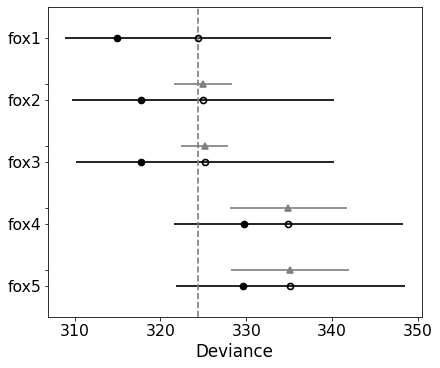

In [102]:
az.plot_compare(compare_df);

### Interpretation

Recall the DAG

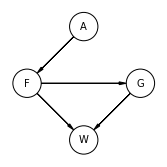

In [99]:
dag0 = CausalGraphicalModel(
    nodes=["A", "F", "G", "W"]
        , edges=[("A", "F"), ("F", "G"), ("F", "W"), ("G", "W")]
)
pgm = daft.PGM()
# coordinates are column, row
coordinates = {"A": (1, 0), "F": (0, 1), "G": (2, 1), "W": (1,2)}
for node in dag0.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag0.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis()

Models 1 and 2 are basically identical, because knowing Area adds little once we know Food.

Richard: _The differences are small and smaller in all cases than
the standard error of the difference. WAIC sees these models are tied._

_This makes sense, given the DAG, because as long as a model has groupsize in it,
we can include either avgfood or area or both and get the same inferences._